In [24]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [40]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array or list): High-resolution images
        - lr_images (numpy array or list): Low-resolution images
        - max_images (int, optional): Maximum number of images to use.
        """
        # Convert lists to numpy arrays if needed
        hr_images = np.array(hr_images)
        lr_images = np.array(lr_images)
        
        # Ensure images are 4D tensors: (N, C, H, W)
        if len(hr_images.shape) == 3:
            hr_images = hr_images[:, np.newaxis, :, :]
        if len(lr_images.shape) == 3:
            lr_images = lr_images[:, np.newaxis, :, :]
        
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)
    
    def __getitem__(self, idx):
        # Get your images
        lr = self.lr_images[idx]  
        hr = self.hr_images[idx]
    
        # Ensure 4D tensor for interpolation
        lr = lr.unsqueeze(0) if lr.dim() == 3 else lr
        hr = hr.unsqueeze(0) if hr.dim() == 3 else hr
    
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr, 
                                        size=(hr.shape[2], hr.shape[3]), 
                                        mode='bilinear', 
                                        align_corners=False)
        
        # Remove extra batch dimension
        lr_interpolated = lr_interpolated.squeeze(0)
        hr = hr.squeeze(0)
    
        return lr_interpolated, hr
        
    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        # Handle potential zero division
        x_min, x_max = np.min(x), np.max(x)
        return (x - x_min) / (x_max - x_min) if x_max > x_min else x


In [26]:
lr_folder = "/kaggle/input/sr-3-datset/Dataset/LR"
hr_folder = "/kaggle/input/sr-3-datset/Dataset/HR"

In [27]:
import os
def load_and_preprocess_data(lr_folder, hr_folder):

    print("Loading data from folders...")
 
    lr_images_list = []
    hr_images_list = []
    for filename in os.listdir(lr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(lr_folder, filename)
            images = np.load(file_path)
            lr_images_list.append(images)
    
    for filename in os.listdir(hr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(hr_folder, filename)
            images = np.load(file_path)
            hr_images_list.append(images)
    
    lr_images = np.concatenate(lr_images_list, axis=0)
    hr_images = np.concatenate(hr_images_list, axis=0)
    
    print(f"Loaded {len(lr_images)} low-resolution images")
    print(f"Loaded {len(hr_images)} high-resolution images")
    
    print(f"LR Image Shape: {lr_images[0].shape}")
    print(f"HR Image Shape: {hr_images[0].shape}")
    
    lr_images = lr_images.astype(np.float32)
    hr_images = hr_images.astype(np.float32)

    return lr_images, hr_images
    
lr_images, hr_images = load_and_preprocess_data(lr_folder, hr_folder)

Loading data from folders...
Loaded 300 low-resolution images
Loaded 300 high-resolution images
LR Image Shape: (64, 64)
HR Image Shape: (128, 128)


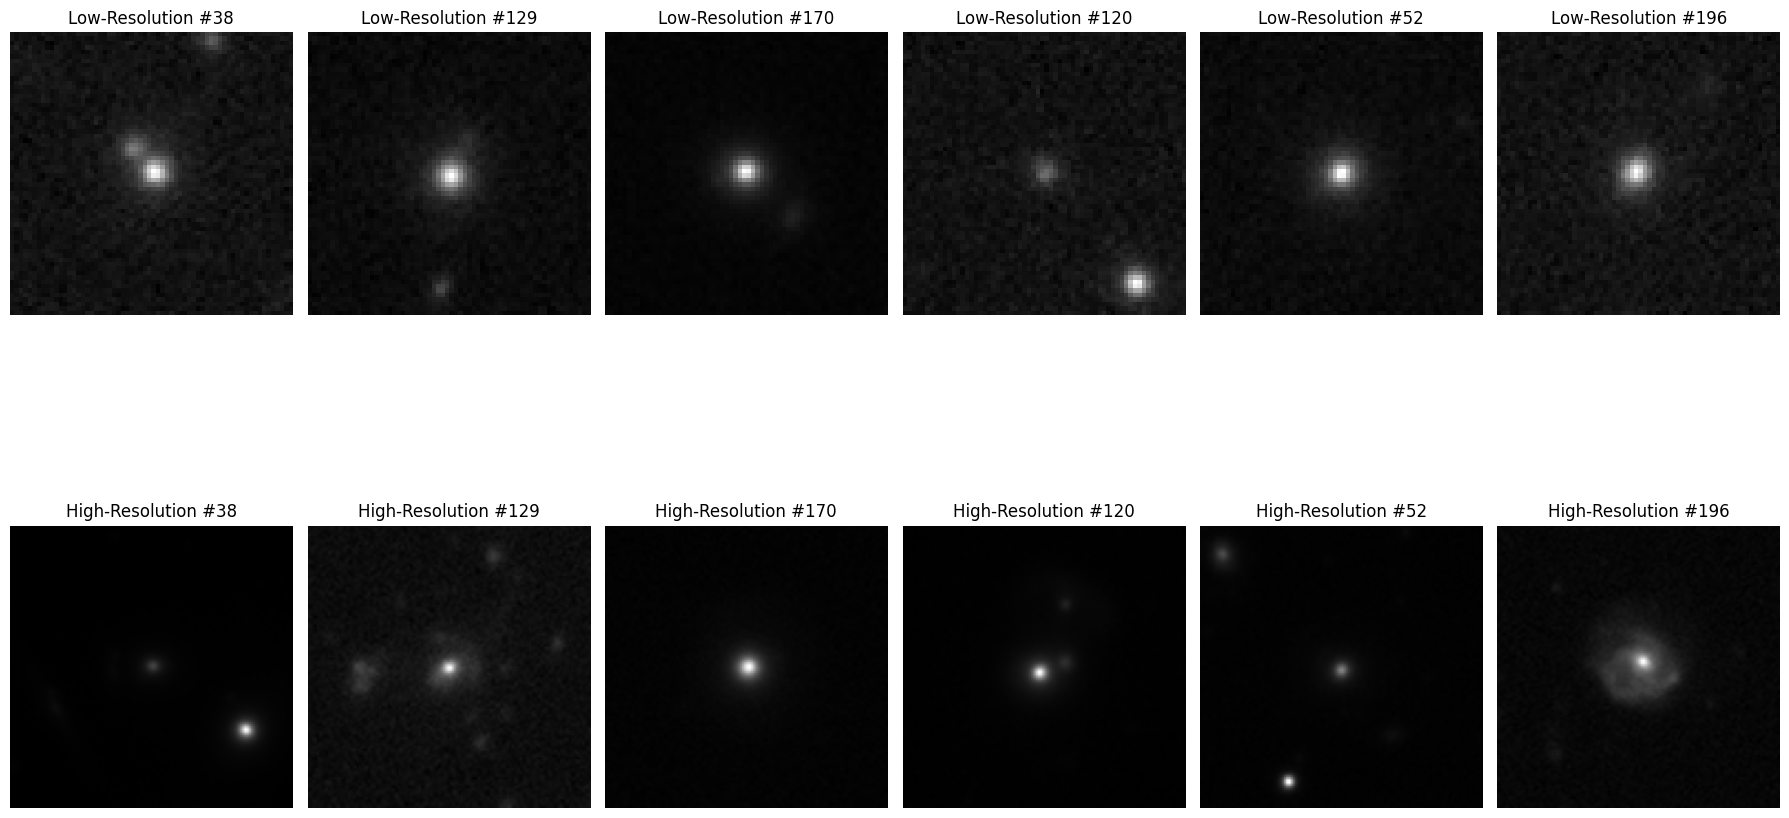

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_samples(hr_images, lr_images, n_samples=5):

    indices = np.random.choice(len(hr_images), n_samples, replace=False)
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 12))
    for i, idx in enumerate(indices):
        axes[0, i].imshow(lr_images[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Low-Resolution #{idx}")
        axes[0, i].axis('off')
        axes[1, i].imshow(hr_images[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f"High-Resolution #{idx}")
        axes[1, i].axis('off')
        
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

visualize_samples(hr_images, lr_images, n_samples=6)

In [29]:
print(f"Total HR Images: {len(hr_images)}")
print(f"Total LR Images: {len(lr_images)}")


Total HR Images: 300
Total LR Images: 300


In [30]:
# Rest of your data loading code remains the same
total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset(hr_images[train_indices], lr_images[train_indices])
test_dataset = SuperresDataset(hr_images[test_indices], lr_images[test_indices])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.04090357944369316, Max value: 0.9551815390586853


In [32]:
import torch
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        # self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=False)  # Upscale 64x64 -> 128x128
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # x = self.upsample(x)  # First upsample
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Create the model
model = SRCNN()


In [33]:
import torch
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=30):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()        
        running_loss = 0.0
        total_batches = len(train_loader)
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)             
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.8f}'})
        scheduler.step()
        epoch_loss = running_loss / total_batches
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}')
    
    print('Finished Training')

In [34]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

criteria = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
train(model, train_loader, criteria, optimizer, scheduler, device, num_epochs=50)

Epoch 1/50, Loss: 0.02817594


Epoch 2/50, Loss: 0.02083529


Epoch 3/50, Loss: 0.02040894


Epoch 4/50, Loss: 0.02055548


Epoch 5/50, Loss: 0.02077797


Epoch 6/50, Loss: 0.02054103


Epoch 7/50, Loss: 0.02075797


Epoch 8/50, Loss: 0.02043375


Epoch 9/50, Loss: 0.02003510


Epoch 10/50, Loss: 0.02112795


Epoch 11/50, Loss: 0.02053083


Epoch 12/50, Loss: 0.02037433


Epoch 13/50, Loss: 0.02039889


Epoch 14/50, Loss: 0.02036579


Epoch 15/50, Loss: 0.02025015


Epoch 16/50, Loss: 0.01978143


Epoch 17/50, Loss: 0.01962600


Epoch 18/50, Loss: 0.01967030


Epoch 19/50, Loss: 0.01941038


Epoch 20/50, Loss: 0.01944156


Epoch 21/50, Loss: 0.01954960


Epoch 22/50, Loss: 0.01923535


Epoch 23/50, Loss: 0.01919390


Epoch 24/50, Loss: 0.01915423


Epoch 25/50, Loss: 0.01912543


Epoch 26/50, Loss: 0.01919389


Epoch 27/50, Loss: 0.01910821


Epoch 28/50, Loss: 0.01907013


Epoch 29/50, Loss: 0.01912881


Epoch 30/50, Loss: 0.01919371


Epoch 31/50, Loss: 0.01909902


Epoch 32/50, Loss: 0.01907771


Epoch 33/50, Loss: 0.01930750


Epoch 34/50, Loss: 0.01910298


Epoch 35/50, Loss: 0.01901392


Epoch 36/50, Loss: 0.01904502


Epoch 37/50, Loss: 0.01901468


Epoch 38/50, Loss: 0.01907852


Epoch 39/50, Loss: 0.01921328


Epoch 40/50, Loss: 0.01917215


Epoch 41/50, Loss: 0.01901029


Epoch 42/50, Loss: 0.01900688


Epoch 43/50, Loss: 0.01897797


Epoch 44/50, Loss: 0.01905446


Epoch 45/50, Loss: 0.01896160


Epoch 46/50, Loss: 0.01898650


Epoch 47/50, Loss: 0.01897277


Epoch 48/50, Loss: 0.01898626


Epoch 49/50, Loss: 0.01908945


Epoch 50/50, Loss: 0.01905064
Finished Training


In [35]:
save_path = "/kaggle/working/SRCNN.pth"
torch.save(model.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [36]:
!pip install pytorch_msssim

In [37]:
import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate(model, test_loader, device):
    model.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = model(lr)
            
            # Ensure sr and hr have the same size
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
            
            # Calculate metrics for each image in the batch
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    
    # Calculate average scores
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }

results = evaluate(model, test_loader, device)

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 73.23it/s]


In [38]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 26.02
Average SSIM: 0.5905
Average MSE: 0.002924
Average L1 Loss: 0.039648
